<a id="section__top"></a>
## Project 2 - Ames Housing Data - Modeling
​
General Assembly DSI CC7 Project 2
Anne Kerr - SF
​
Due March 22, 2019
***
​
In the first notebook for this project I explored and cleaned the dataset, and selected a feature set with which to begin modelling. I used a standard linear regression on non-scaled data to get baseline scores for two different feature sets. 
<br><br>
In this notebook I read in the cleaned data and attempt regularization techniques. I decided to use LassoCV and RidgeCV to take advantage of the built in cross validation features. These models required scaled data. I also did the standard linear regression on the scaled data as a basis for comparison. As I mentioned in the previous notebook, the linear regression performed much better on non-scaled data. I am not sure why that is, and would like to explore it further in the future. 

LassoCV produced the best score, so this is the one I chose to create my final model.


In [1]:

from sklearn.pipeline import Pipeline
#Importing NumPy and Pandas.
import numpy as np
import pandas as pd
import pickle

import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler   #transformers

import matplotlib.pyplot as plt



import seaborn as sns
import scipy.stats as stats

# This magic line will allow you to generate plots
# within the Jupyter notebook.
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Read the cleaned data saved previously

In [3]:
## Training data
df = pd.read_csv('../data/train_cleaned.csv')
# ## Read in test data
X_validate = pd.read_csv('../data/validation_file.csv')

Check the shapes. I still need to remove the SalePrice from the training set, and the ID columns from the test set. At this point I am looking for the test set to have one more column than the training set. Once these changes have been made they will have the same number of columns. This is required for modeling.

In [4]:
df.shape

(2048, 94)

In [5]:
X_validate.shape

(879, 95)

In [6]:
df.head()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,House Style_SFoyer,House Style_SLvl,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_NA,Garage Cond_Po,Garage Cond_TA,Paved Drive_P,Paved Drive_Y,SalePrice
0,60,0.0,13517,6,8,1976,2005,289.0,533.0,0.0,...,0,0,0,0,0,0,1,0,1,130500
1,60,43.0,11492,7,5,1996,1997,132.0,637.0,0.0,...,0,0,0,0,0,0,1,0,1,220000
2,20,68.0,7922,5,7,1953,2007,0.0,731.0,0.0,...,0,0,0,0,0,0,1,0,1,109000
3,60,73.0,9802,5,5,2006,2007,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,174000
4,50,82.0,14235,6,8,1900,1993,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,138500


In [7]:
X_validate.head()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,House Style_2Story,House Style_SFoyer,House Style_SLvl,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_NA,Garage Cond_Po,Garage Cond_TA,Paved Drive_P,Paved Drive_Y
0,2658,902301120,190,69.0,9142,6,8,1910,1950,0.0,...,1,0,0,0,0,0,1,0,0,1
1,2718,905108090,90,0.0,9662,5,4,1977,1977,0.0,...,0,0,0,0,0,0,0,1,0,1
2,2414,528218130,60,58.0,17104,7,5,2006,2006,0.0,...,1,0,0,0,0,0,0,1,0,1
3,1989,902207150,30,60.0,8520,5,6,1923,2006,0.0,...,0,0,0,0,0,0,0,1,0,0
4,625,535105100,20,0.0,9500,6,5,1963,1963,247.0,...,0,0,0,0,0,0,0,1,0,1


A quick inspection of the first few rows of each file shows they are as expected. I can now make the changes needed to get ready for modeling.

In [8]:
X_validate_Preds = X_validate.drop(columns=['Id','PID'])

In [9]:
y = df['SalePrice']
X = df.drop(columns=['SalePrice'])


In [10]:
X.shape

(2048, 93)

Split the training data into training and test sets.

In [11]:
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                test_size=0.5, random_state=42) 

In [12]:
X_train.shape

(1024, 93)

###  Instantiate three models. Score each and select the best.

Scale the data to be used for all three tests.

In [13]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

Print the first two rows and columns, just to check that the date was transformed as expected.

In [14]:

X_train_scaled[:2, :2]

array([[-0.86813594,  0.78187532],
       [ 0.57617146,  0.10516183]])

In [15]:
#First two rows
X_test_scaled[:2, :2]

array([[-0.86813594,  0.04631718],
       [-0.86813594, -1.71902236]])

Score standard linear regression


In [16]:
lr = LinearRegression()
lasso = LassoCV(cv=5)  #for each alpha doing a 5-fold cross val
ridge = RidgeCV()

In [17]:
cross_val_score(lr, X_train_scaled, y_train, cv=5).mean()

-1649928.873436034

In [18]:
cross_val_score(lr, X_test_scaled, y_test, cv=5).mean()

-7.857888220248498e+17

Score LassoCV


In [19]:
cross_val_score(lasso, X_train_scaled, y_train, cv=5).mean()

0.8217080183290335

In [20]:
cross_val_score(lasso, X_test_scaled, y_test, cv=5).mean()

0.8444134652558513

Score RidgeCV

In [21]:
cross_val_score(ridge, X_train_scaled, y_train, cv=5).mean()

0.81686296125547

In [22]:
cross_val_score(ridge, X_test_scaled, y_train, cv=5).mean()

-0.10254609687920997

The models haven't been fitted yet. The above is a rough approximation of how
they would perform on unseen data

Lasso gives the best score, so I will proceed to use this model for my predictions.

### Predicting home prices with the LassoCV model

In [23]:
lasso.fit(X_train_scaled, y_train);

In [24]:
lasso.alpha_

775.7519839550303

In [25]:
np.shape(lasso.coef_)

(93,)

In [26]:
#Etract the coefficients for each variable and sor by abs val visuallize the predictive value of each
##This code adapted from a sample provided by from James Hampton, and modified by Mark 
coef_df = pd.DataFrame([lasso.coef_, X.columns], index = ['Coefficients', 'Features']).T
coef_df = coef_df.set_index('Features')
coef_df['Coefficients'] = np.abs(coef_df['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients',ascending=False)
coef_df.head(10)

,Coefficients
Features,
Overall Qual,19551.9
Gr Liv Area,18113.3
Neighborhood_NridgHt,13065.2
Neighborhood_StoneBr,11130.9
Year Built,9018.73
Garage Cars,7444.56
1st Flr SF,6152.22
MS SubClass,5453.19
Screen Porch,4586.79


Text(0.5, 0, 'Strenth of Predictor')

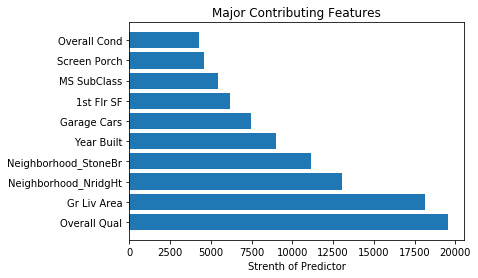

In [27]:
plt.barh(y=coef_df.index[:10], width=coef_df['Coefficients'][0:10]);
plt.title('Major Contributing Features')
plt.xlabel('Strenth of Predictor')

In [28]:
lasso.intercept_

181918.591796875

### Inerpretation of the model

The Lasso model reduces the beta coefficients of the features that do not contribute to 0.  The above chart shows the top 10 predictors. Overall quality, acording to this model, is the strongest. With a coefficient of 19,552 (rounded) this means that, all other factors remaining constant, with every unit increase in overall quality, we can expect the price of the home to increase by approximately $19K. The challenge, of course, is to define unit of quality. 

The intercept value is 181918, which means that if all features in our model are reduced to zero, the home would cost about $182K. This is a resonable, given that some of the features increase the value of a home, while other decresase it, and the mean and median sale prices are \$181.5K \$162.5K, respectively.





#### Prediction with the new model
The next step is to take the new model and test its predicrtions against the test split, and see how well it did. To do this I will compare the true prices with the predicted prices, and plot the residuals.


In [29]:
pred = lasso.predict(X_test_scaled)
residuals = y_test - pred
residuals[:5]  #look at the first five

1476     7590.845338
693      7695.556767
100     -3610.333863
1421    12730.686166
1810    12472.590090
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Distribution of Residuals')

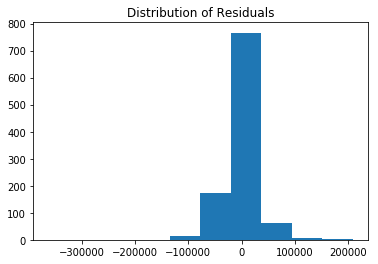

In [30]:
plt.hist(residuals);
plt.title('Distribution of Residuals')

***
Looking for a normal distribution, centered around zero. 
***

Text(0.5, 1.0, 'Transformed Residuals')

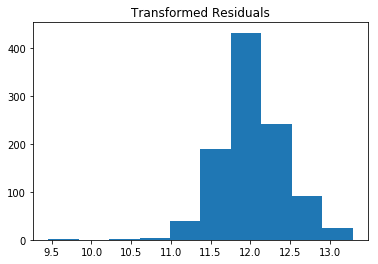

In [31]:
plt.hist(np.log(y_test));
plt.title('Transformed Residuals')

In [32]:
sample_prices = y_test.values[0]
np.log(sample_prices)

11.77452020265869

Text(0.5, 1.0, 'Comparing Predicted Prices with Residuals')

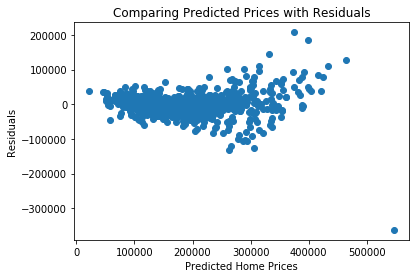

In [33]:
#interdcept 182000
#slope for quality is 19500
plt.scatter(x=pred,y=residuals)
plt.xlabel('Predicted Home Prices')
plt.ylabel('Residuals')
plt.title('Comparing Predicted Prices with Residuals')

### Summary 

The model suggests that while location is important (Being in Northridge Heights and Stonebrook were the 3rd and 4th strongest predictors), size and quality are the even more important for predicting home prices in Ames. 

This is just a start, however. Much more could be done to improve the model. As I work to improve the model I will spend more time looking at the data before constructing my final model. I will break it down into logical categories. E.g., house features, property features, location features, etc. I may also break house features down into garage, room size, etc. I would like to constuct interaction terms to test, and run polynomial features to see what ineraction terms it comes up with. I would also like to spend more time cleaning the categorical values so I could include more of them in the model, and treat the ranking numeric variables as such rather than lumping them in with all the numeric features. 



